# Introduction

The following is a test of the algorithm found in a popular GPL licensed algorithm called **The Flame Draves Algorithm** found here:

http://www.flam3.com/flame_draves.pdf

This algorithm is used to generate fractal frames in a beautiful way.

Testing the plotting mechanism


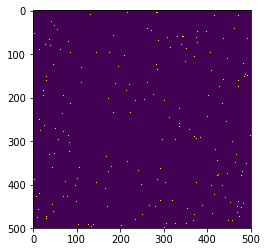

In [1]:
# Test and create a way to plot a numpy matrix or 2D array
import random
import math
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline


def plot_matrix(mat):
    fig, ax = plt.subplots()
    h = ax.imshow(mat)
    plt.show()

def plot_points(mat, img_size=(500,500)):
    # This should take a matrix of shape (M, 2) where
    # M is the number of points. 
    # The values in mat could be anything, but gaurentee some shape
    # Therefore this function dictates the size of the image in pixels
    # TODO: zoom to remove low density areas
    mat = np.array(mat).T
    x_max, x_min = mat[0].max(), mat[0].min()
    y_max, y_min = mat[1].max(), mat[1].min()
    x_rng, y_rng = x_max - x_min, y_max - y_min
    mul_factor_x = (img_size[0]-1)/x_rng
    mul_factor_y = (img_size[1]-1)/y_rng
    img = np.zeros(img_size)
    for x, y in mat.T:
        img[int((x - x_min)*mul_factor_x),int((y - y_min)*mul_factor_y)] = 1
    plot_matrix(img)
    

M = 1000
hl = np.random.random(size=(M, 2))

# Test this
print("Testing the plotting mechanism")
plot_points(hl)

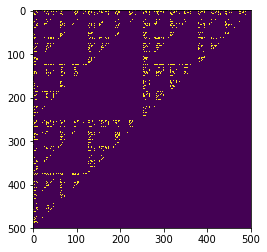

In [2]:
# Making sierpinski's gasket
def sierpinski(N=500, iters=10000):
    def F0(x,y):
        return (x/2, y/2)

    def F1(x,y):
        return ((x+1)/2, y/2)

    def F2(x,y):
        return (x/2, (y+1)/2)

    F_array = (F0, F1, F2)    
    
    x, y = (random.randint(0,N-1), random.randint(0,N-1))
    mat = []
    for i in range(iters):
        ri = random.randint(0,2)
        x, y = F_array[ri](x, y)
        if i < 20:
            continue
        mat.append([int(x*300),int(y*300)])
    return mat
        
        
chaos = sierpinski()
plot_points(chaos)

In [3]:
# Basic variations in the implementation of the flam3
def r2(x, y):
    return (x*x) + (y*y)

def r(x, y):
    return r2(x,y)**0.5

def v0(x, y):
    # Linear
    return (x,y)

def v1(x, y):
    # Sinusoidal
    return (math.sin(x), math.sin(y))

def v2(x, y):
    # Spherical
    r2_calced = r2(x,y)
    return (x/r2_calced, y/r2_calced)

def v3(x, y):
    # Swirl
    r2_calced = r2(x,y)
    sin_r2 = np.sin(r2_calced)
    cos_r2 = np.cos(r2_calced)
    return np.array([x*sin_r2 - y*cos_r2, x*cos_r2 + y*sin_r2]).T

def v4(x, y):
    # Horseshoe
    x = np.array(x)
    y = np.array(y)
    return np.array([(x-y)*(x+y)/r(x,y), 2*x*y]).T

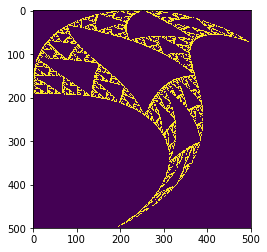

262 ms ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
# Making sierpinski's gasket
def F0(x,y):
    return (x/2, y/2)

def F1(x,y):
    return ((x+1)/2, y/2)

def F2(x,y):
    return (x/2, (y+1)/2)

def r2(x, y):
    return (x*x) + (y*y)

def v3(x, y):
    # Swirl
    r2_calced = r2(x,y)
    sin_r2 = math.sin(r2_calced)
    cos_r2 = math.cos(r2_calced)
    return [x*sin_r2 - y*cos_r2, x*cos_r2 + y*sin_r2]    

F_array = (F0, F1, F2)    

def sierpinski(N=500, iters=60000):    
    x, y = (1,1)
    mat = []
    for i in range(iters):
        ri = random.randint(0,2)
        x, y = F_array[ri](x, y)
        if i < 1000:
            continue
        
        x1, y1 = x, y
        x1, y1 = v3(x*1.1, y*1.1) # Increase for more swirl!
        mat.append([x1,y1])
    return mat
        
        
chaos = sierpinski()
plot_points(chaos)
%timeit sierpinski()

## Making it faster

We can easily make this code faster using two optomization possibilities:

1. JIT compiling using numba
2. Converting to Cython


### First the naiive JIT version:

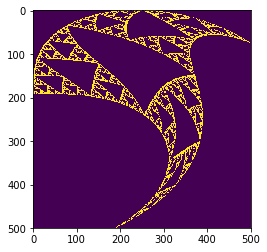

262 ms ± 54.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
from numba import jit
import math

@jit
def F0(x,y):
    return (x/2, y/2)

@jit
def F1(x,y):
    return ((x+1)/2, y/2)

@jit
def F2(x,y):
    return (x/2, (y+1)/2)

@jit
def r2(x, y):
    return (x*x) + (y*y)

@jit
def v3(x, y):
    # Swirl
    r2_calced = r2(x,y)
    sin_r2 = math.sin(r2_calced)
    cos_r2 = math.cos(r2_calced)
    return [x*sin_r2 - y*cos_r2, x*cos_r2 + y*sin_r2]

F_array = (F0, F1, F2)    

@jit
def sierpinski(N=500, iters=60000):
    x, y = (1,1)
    mat = []
    for i in range(iters):
        ri = random.randint(0,2)
        x, y = F_array[ri](x, y)
        if i < 1000:
            continue
        
        x1, y1 = x, y
        x1, y1 = v3(x*1.1, y*1.1) # Increase for more swirl!
        mat.append([x1,y1])
    return mat
        
        
chaos = sierpinski()
plot_points(chaos)
%timeit sierpinski()

This doubled the speed from about 200ms to 100ms. Easy! But can we do better?

### JIT version expanded to use static types

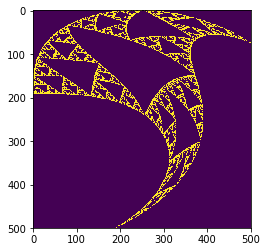

4.4 ms ± 763 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
from numba import jit, float32
import numba as nb
import numpy as np
import math

@nb.jit(nb.types.UniTuple(nb.float64,2)(nb.float64,nb.float64),nopython=True)
def F0(x,y):
    return (x/2, y/2)

@nb.jit(nb.types.UniTuple(nb.float64,2)(nb.float64,nb.float64),nopython=True)
def F1(x,y):
    return ((x+1)/2, y/2)

@nb.jit(nb.types.UniTuple(nb.float64,2)(nb.float64,nb.float64),nopython=True)
def F2(x,y):
    return (x/2, (y+1)/2)

@nb.jit(nb.float64(nb.float64,nb.float64),nopython=True)
def r2(x, y):
    return (x*x) + (y*y)

@nb.jit(nb.types.UniTuple(nb.float64,2)(nb.float64,nb.float64),nopython=True)
def v3(x, y):
    # Swirl
    r2_calced = (x*x) + (y*y)
    sin_r2 = math.sin(r2_calced)
    cos_r2 = math.cos(r2_calced)
    return (x*sin_r2 - y*cos_r2, x*cos_r2 + y*sin_r2)

@nb.jit(nopython=True)
def sierpinski(N=500, iters=60000, dry_fire=100):
    x: nb.float64 = 1.
    y: nb.float64 = 1.
    # We have to know how many 
    mat = np.zeros((iters-dry_fire, 2))
    for i in range(iters):
        ri: nb.int32 = random.randint(0,2)
        if ri == 0:
            x, y = F0(x, y)
        elif ri == 1:
            x, y = F1(x, y)
        else:
            x, y = F2(x, y)
            
        if i >= dry_fire:
            x1, y1 = x, y
            x1, y1 = v3(x*1.1, y*1.1) # Increase for more swirl!
            mat[i-dry_fire] = x1, y1
    return mat
        
        
chaos = sierpinski()
plot_points(chaos)
%timeit sierpinski()

Now we went, just by setting expected input and outpu types, from 100ms to ~2ms. A **50x** speedup from naiive Numba JIT. 

### How does that compare to Cython?

To work with Cython we have to expand the entire code-base to be friendly with Cython. Numba did a good job with minimal work, but Cython requires a lot of refactoring and knowledge on how to move from Python to the Python-like Cython language. 

The approach follows a basic principle: you are limited to basic C-types and actions.

+ Return basic types (not tuples or numpy arrays)
+ Expand loops and using indexing
+ Try to create and use as few arrays as possible

The result is the following:

In [7]:
%load_ext Cython

In [8]:
%%cython

import numpy as np
cimport numpy as np
import cython
cimport cython
from libc.math cimport sin, cos
from cpython cimport array

# Making sierpinski's gasket
cdef double F0_x(double x):
    return x/2

cdef double F0_y(double y):
    return y/2

cdef double F1_x(double x):
    return (x+1)/2
    
cdef double F1_y(double y):
    return y/2

cdef double F2_x(double x):
    return x/2

cdef double F2_y(double y):
    return (y+1)/2

cdef double r2(double x, double y):
    return (x*x) + (y*y)

cdef double v3_x(double x, double y, double r2_calced):
    # Swirl
    cdef double sin_r2 = sin(r2_calced)
    cdef double cos_r2 = cos(r2_calced)
    return x*sin_r2 - y*cos_r2

cdef double v3_y(double x, double y, double r2_calced):
    # Swirl
    cdef double sin_r2 = sin(r2_calced)
    cdef double cos_r2 = cos(r2_calced)
    return x*cos_r2 + y*sin_r2

cpdef np.ndarray sierpinski(int N=500, int iters=60000, int dry_fire=100):   
    cdef double x = 1.
    cdef double y = 1.
    cdef double x1 = 1.
    cdef double y1 = 1.
    cdef np.ndarray[double, ndim=2] mat = np.zeros((iters-dry_fire, 2), dtype=np.double)
    cdef np.ndarray[int, ndim=1] ri = np.random.randint(3,  size=iters, dtype=int)
    cdef int i
    cdef int r
    cdef double r2_calced
    for i in range(iters):
        r = ri[i]
        if r == 0:
            x = F0_x(x)
            y = F0_y(y)
        elif r == 1:
            x = F1_x(x)
            y = F1_y(y)
        else:
            x = F2_x(x)
            y = F2_y(y)            
        if i >= 1000:
            r2_calced = r2(x, y)
            x1 = v3_x(x*1.1, y*1.1, r2_calced)
            y1 = v3_y(x*1.1, y*1.1, r2_calced)
            mat[i-dry_fire, 0] = x1
            mat[i-dry_fire, 1] = y1
    return mat
        
        
chaos = sierpinski()

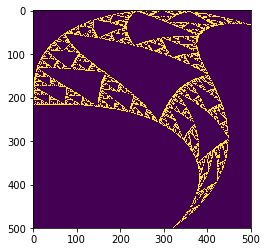

3.72 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
plot_points(chaos)
%timeit sierpinski()

Amazingly, Cython beats Numba:

+ Numba ran in 4.4ms
+ Cython ran in 3.72ms

But the question remains: was the time spend optimizing in Cython worth it? 

### Looking at the Cython code

Cython provides a friendly way to debug speed improvements using Jupyter. Above we saw highlighted sections of code indicating a large amount of boilerplate code to allow Cython to talk to Python Objects. The darker the highlight, the smaller the speed improvements. 

Notice that the only dark highlights are the following:

+ `numpy` import
+ `cpdef` function
+ `ndarray` objects

The lighter highlights are always index accessors to our `ndarray` objects. 

I take for granted that this could be further sped up in both instances, but for now this code runs quickly enough that we can call this experiment a success.